In [1]:
'''List of packages required for running the notebook. 
Install also the package 'rise' to run the jupyter presentation.
'''

# Import main packages 
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cmap
from IPython.display import Image
%matplotlib inline
from sklearn.linear_model import LinearRegression

# Import packages for coordinate conversion
import pyproj 

# Import packages for visualization 
import datetime
import time
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
import cartopy.crs as ccrs
import cartopy.io.img_tiles as cimgt
import cartopy
from mpl_toolkits import mplot3d

# Import packages for time animation
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

# Import packages for animation
import matplotlib.animation as animation
import io
import base64
from IPython.display import HTML

# Import useful packages
import copy
import warnings
warnings.filterwarnings("ignore")

# <center> Earthquake Data Analysis 

 **Michele Guadagnini** - 1230663 | **Alessandro Lambertini** - 1242885 
 
 **Alice Pagano** - 1236916 | **Michele Puppin** - 1227474
 
 *Padova, 13 March 2020*


In this project we consider a set of data representing earthquakes happened between the $1^{st}$ January 1982 and $28^{th}$ June 2011. The dataset is analyzed in order to compute the distribution of earthquakes in space and time and to visualize properly the process.

# Index <a class="anchor" id="0"></a>

1. [Dataset description](#1)
2. [Visualization](#2) <br>
    2.1. [Visualization of triggered events](#2.1)<br>
    2.2. [Plot of magnitude per month](#2.2)<br>
    2.3. [Visualization in space and time](#2.3)<br>   
3. [Distribution of waiting time $P_m(t)$](#3) <br>
    3.1. [Histogram with regular binning](#3.1)<br>
    3.2. [Histogram with logarithmic binning](#3.2)<br>
    3.3. [Linear regression with tuning of lower cutoff](#3.3) <br>
    3.4. [Analysis for different values of $m$](#3.4)<br>
4. [Distribution of distances $P_m(r)$](#4)<br>
    4.1. [Histogram with regular binning](#4.1)<br>
    4.2. [Histogram with logarithmic binning](#4.2)<br>
    4.3. [Linear regression with tuning of lower cutoff](#4.3) <br>
    4.4. [Analysis for different values of $R$](#4.4)<br>
5. [Distribution of waiting time below a certain distance $P_{m,R}(t)$](#5)<br>
    5.1. [Histogram with regular binning](#5.1)<br>
    5.2. [Histogram with logarithmic binning](#5.2)<br>
    5.3. [Linear regression with tuning of lower cutoff](#5.3)<br>
    5.4. [Analysis for different values of $m$ and $R$](#5.4)<br>   
6. [Rescaling](#6)<br>
    6.1. [Rescaling $P_m(t)$](#6.1)<br>
    6.2. [Rescaling  $P_m(r)$](#6.2)<br>
    6.3. [Reascaling $P_{m,R}(t)$](#6.3)<br> 
7. [Conclusion](#7)<br>

## 1 - Dataset description <a class="anchor" id="1"></a>
* [Index](#0)

The dataset is organized in the following way: 

* The first column cointains the index of the event.
* The second column contains the index of the previous event that triggered it (-1 if no ancestor is found).
* The third column contains time in seconds from 0:00 of the $1^{st}$ January 1982 at which the earthquakes took place.
* The fourth column corresponds to the magnitude of the earthquake in a range of [0,8].
* Last three columns corresponds to the 3D  Euclidean coordinates in meters of the earthquake hypocenter.

In [2]:
# Read data from file and make sure earthquakes are ordered by time
cols = ['index', 'trigger', 'time', 'magnitude', 'X', 'Y', 'Z']
df = pd.read_table("SouthCalifornia-1982-2011_Physics-of-Data.dat",sep=" ",header=None)
df.columns = cols
df = df.sort_values(by = ['time'])
df.head()

,index,trigger,time,magnitude,X,Y,Z
0,0,-1,0.00000,2.71,-2571956,-4627162,3520602
1,1,0,36501.39072,2.12,-2363740,-4787011,3461373
2,2,0,37488.27744,2.33,-2363746,-4786942,3461232
3,3,0,47982.51648,2.57,-2475085,-4664024,3548479
4,4,0,60268.57056,2.98,-2238642,-4839098,3469546


In order to visualize earthquakes, we convert Euclidean coordinates of hypocenters (X, Y, Z) to geographic coordinates (longitude, latitude, depth) using the PyProj package. We consider a geographic coordinate system which uses a reference ellipsoid as an approximation of earth surface. In this case we use WGS-84 coordinate system, whose parameters are:

* **Semi-major axis**: a = 6 378 137,000 000 m;

* **Semi-minor axis**: b = 6 356 752,314 245 m;

* **Eccentricity**: f = 1/298,257223563;

<center>
<img src='https://upload.wikimedia.org/wikipedia/commons/thumb/3/3e/WGS84_mean_Earth_radius.svg/440px-WGS84_mean_Earth_radius.svg.png' alt="" width="" height="" style="">
<figcaption>Figure: Reppresentation of the reference ellipsoid in WGS-84. </figcaption>
</center>


The position with respect to the reference ellipsoid is given by: 

* longitude $\lambda$: measures the rotational angle between the zero meridian and the measured point. By convention it is expressed in degrees ranging from $−180°$ to $+180°$.

* latitude $\phi$: measures how close to the poles or equator a point is along a meridian, and is represented as an angle from $−90°$ to $+90°$, where $0°$ is the equator. 

* depth $h$: ellipsoidal height of the point above or below the reference ellipsoid along its normal.

If these coordinates are given, one can compute the Euclidean coordinates of the point as follows:

\begin{aligned}X&={\big (}N(\phi )+h{\big )}\cos {\phi }\cos {\lambda }\\Y&={\big (}N(\phi )+h{\big )}\cos {\phi }\sin {\lambda }\\Z&=\left({\frac {b^{2}}{a^{2}}}N(\phi )+h\right)\sin {\phi }\end{aligned}
where

$$N(\phi )= \frac {a^{2}} {\sqrt {a^{2}\cos ^{2}\phi +b^{2}\sin ^{2}\phi}}$$

and $a$ and $b$ are the equatorial radius (semi-major axis) and the polar radius (semi-minor axis), respectively. $N$ is the radius of curvature in the prime vertical.

<center>
<img src='https://gssc.esa.int/navipedia/images/e/e8/Ellipsoidal_%26_Cartesian_Coord_Conv.png' alt="" width="" height="" style="">
<figcaption>Figure: Reppresentation of Eucledian and geographic coordinates. </figcaption>
</center>

In [3]:
# With PyProj it is possible to tranform cartesian coordinates into geographic coordinates

# Definition of the two reference frames 
ecef = pyproj.Proj(proj='geocent', ellps='WGS84', datum='WGS84') #euclidean
lla  = pyproj.Proj(proj='latlong', ellps='WGS84', datum='WGS84') #latlon

# Coordinates conversion
points = np.array([df.X, df.Y, df.Z])
gcoor  = pd.DataFrame(zip(*(pyproj.transform(ecef, lla, points[0], points[1], points[2], radians=False))))

gcoor.columns = ['longitude', 'latitude', 'depth']
df = pd.concat([df, gcoor], axis=1)

display(df.head()) # Display dataset with new coordinates

display(df.describe()) # Computing some statistics on the dataset

,index,trigger,time,magnitude,X,Y,Z,longitude,latitude,depth
0,0,-1,0.00000,2.71,-2571956,-4627162,3520602,-119.067002,33.803070,-13866.339244
1,1,0,36501.39072,2.12,-2363740,-4787011,3461373,-116.279332,33.133255,-9094.154542
2,2,0,37488.27744,2.33,-2363746,-4786942,3461232,-116.279718,33.132481,-9220.807091
3,3,0,47982.51648,2.57,-2475085,-4664024,3548479,-117.953814,34.081790,-9788.561414
4,4,0,60268.57056,2.98,-2238642,-4839098,3469546,-114.825995,33.229464,-10453.018623


,index,trigger,time,magnitude,X,Y,Z,longitude,latitude,depth
count,110271.000000,110271.000000,1.102710e+05,110271.000000,1.102710e+05,1.102710e+05,1.102710e+05,110271.000000,110271.000000,110271.000000
mean,55135.000000,35859.277625,4.262426e+08,2.457920,-2.388225e+06,-4.691072e+06,3.562612e+06,-116.996259,34.260790,-12044.275282
std,31832.640104,36365.001297,2.598605e+08,0.438374,8.878019e+04,1.237294e+05,1.271897e+05,1.375750,1.383914,4592.149240
min,0.000000,-1.000000,0.000000e+00,2.000000,-2.770239e+06,-5.020849e+06,3.186133e+06,-122.000001,30.198200,-52880.435689
25%,27567.500000,-1.000000,2.115783e+08,2.140000,-2.421620e+06,-4.801152e+06,3.458838e+06,-117.799330,33.146103,-14648.105695
50%,55135.000000,28462.000000,3.551023e+08,2.340000,-2.361829e+06,-4.699729e+06,3.564367e+06,-116.590478,34.263771,-11391.580012
75%,82702.500000,66972.000000,5.952398e+08,2.640000,-2.329898e+06,-4.615062e+06,3.634552e+06,-116.018110,35.027224,-8677.236648
max,110270.000000,110250.000000,9.305667e+08,7.300000,-1.998294e+06,-4.268289e+06,3.876120e+06,-113.083168,37.686553,-308.713189


In order to visualize the process in time and space, we link to each earthquake the respective time in calendar.

In [4]:
# Add columns with the corresponding year and month
offset = (datetime.datetime.fromisoformat('1982-01-01') - datetime.datetime.fromisoformat('1970-01-01')).total_seconds()

df['total_second'] = df['time'] + offset + 8*60*60 

year = np.empty(df['time'].values.shape[0], int)
month = np.empty(df['time'].values.shape[0], int) 
day = np.empty(df['time'].values.shape[0], int) 

for i in range(df['time'].values.shape[0]):
    year[i] = datetime.datetime.fromtimestamp(df['total_second'].values[i]).year 
    month[i] = datetime.datetime.fromtimestamp(df['total_second'].values[i]).month 
    day[i] = datetime.datetime.fromtimestamp(df['total_second'].values[i]).day 
    
df['year'] = year
df['month'] = month
df['day'] = day

## 2 - Visualization <a class="anchor" id="2"></a>
* [Index](#0)

### 2.1 - Visualization of triggered events <a class="anchor" id="2.1"></a>
* [Index](#0)

Joining each event to that with the index of the second column (if not -1), there emerges a set of causal trees. First of all,  we count the number of event triggered by each earthquake in order to visualize efficently the causality.

In [5]:
num_trig = np.zeros(df.shape[0], dtype=int)

counts = df.groupby('trigger')['index'].nunique() # Groupping elements with same trigger, selecting column index and counting the frequency of a trigger
counts[-1] = 0  # Removing counts for events with no ancestor (trigger=-1)

for i in counts.keys(): 
    num_trig[i] = counts[i]

df['num_trig'] = np.array(num_trig)   

We plot the total number of events and the average number of events triggered by earthquakes in different intervals of magnitude with step size of $0.1$. Observing the total number of triggered events, we notice that most of the earthquakes are triggered by events with small magnitude since they are much more. Instead, in the case of the average number of triggered events we deduce that, in relative terms, earthquakes with greater magnitude trigger a larger number of events.

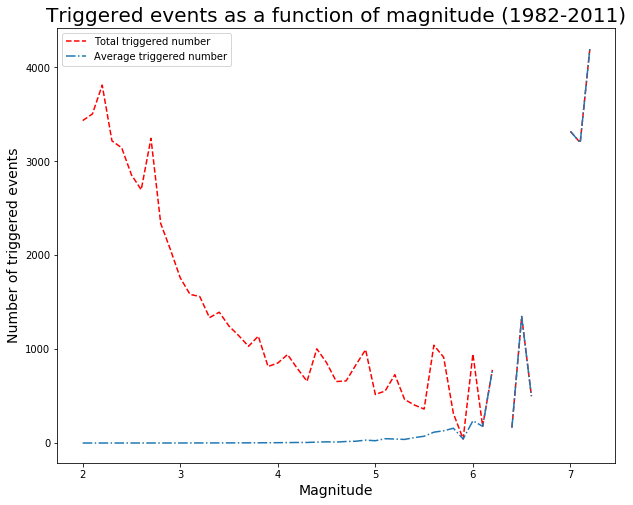

In [6]:
interval_sum = np.arange(df['magnitude'].min(),df['magnitude'].max()+0.1,0.1) # Create the intervals of magnitude
interval_mean = np.arange(df['magnitude'].min(),df['magnitude'].max()+0.1,0.1) # Create the intervals of magnitude

number_sum = []
number_mean = []

for j in range(interval_sum.shape[0]-1): # Sum number of triggered events in the interval
    df_mag = df[np.logical_and(df['magnitude']>=interval_sum[j], df['magnitude']<interval_sum[j+1])]
    if df_mag.shape[0] != 0:
        number_sum.append(df_mag['num_trig'].sum())
    if df_mag.shape[0] == 0:
        number_sum.append(np.nan)      
        
for j in range(interval_mean.shape[0]-1): # Compute the average number of triggered events in the interval
    df_mag = df[np.logical_and(df['magnitude']>=interval_mean[j], df['magnitude']<interval_mean[j+1])]
    number_mean.append(df_mag['num_trig'].mean(axis=0))

fig = plt.figure(figsize=(10, 8))

plt.title("Triggered events as a function of magnitude (1982-2011)", fontsize=20)
plt.xlabel('Magnitude', fontsize=14)
plt.ylabel('Number of triggered events', fontsize=14)
plt.plot(interval_sum[:-1],number_sum,color='red',linestyle='dashed',label='Total triggered number')
plt.plot(interval_mean[:-1],number_mean,color='tab:blue',linestyle='dashdot',label='Average triggered number')  
plt.legend()

We repeat a similar procedure considering depth intervals of $1 \: km$ each. In this case we observe that shallowest earthquakes are the ones that trigger the larger number of events. 

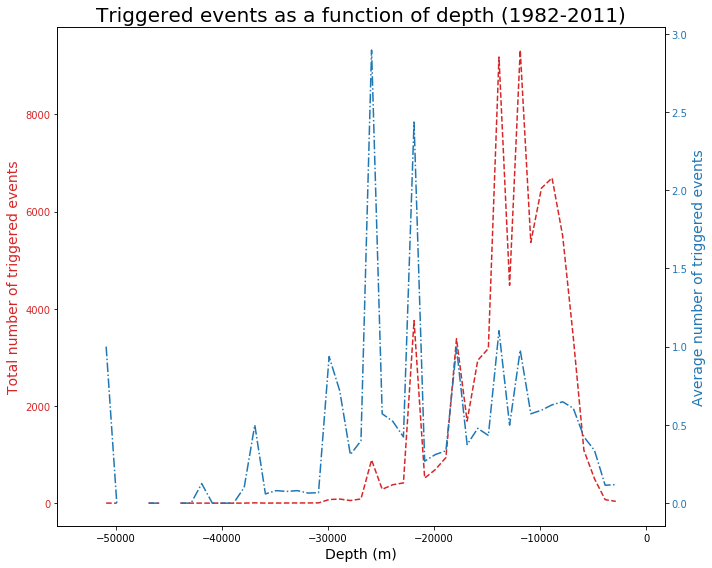

In [7]:
interval_sum = np.arange(df['depth'].min(),df['depth'].max()+1000,1000) # Create the intervals of depth
interval_mean = np.arange(df['depth'].min(),df['depth'].max()+1000,1000) # Create the intervals of depth

number_sum = []
number_mean = []

for j in range(interval_sum.shape[0]-1): # Sum number of triggered events in the interval
    df_dep = df[np.logical_and(df['depth']>=interval_sum[j], df['depth']<interval_sum[j+1])]
    if df_dep.shape[0] != 0:
        number_sum.append(df_dep['num_trig'].sum())
    if df_dep.shape[0] == 0:
        number_sum.append(np.nan)      
        
for j in range(interval_mean.shape[0]-1): # Compute the average number of triggered events in the interval
    df_dep = df[np.logical_and(df['depth']>=interval_mean[j], df['depth']<interval_mean[j+1])]
    number_mean.append(df_dep['num_trig'].mean(axis=0))

fig, ax1 = plt.subplots(figsize=(10, 8))
color = 'tab:red'

plt.title("Triggered events as a function of depth (1982-2011)", fontsize=20)
ax1.set_xlabel('Depth (m)', fontsize=14)
ax1.set_ylabel('Total number of triggered events', fontsize=14,color=color)
ax1.tick_params(axis='y', labelcolor=color)
ax1.plot(interval_sum[:-1],number_sum,color=color,linestyle='dashed',label='Total triggered number')

ax2 = ax1.twinx() 
color = 'tab:blue'
ax2.plot(interval_mean[:-1],number_mean,color=color,linestyle='dashdot',label='Average triggered number')  
ax2.set_ylabel('Average number of triggered events', fontsize=14,color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # Otherwise the right y-label is slightly clipped        
plt.show()

We produce a 3D plot of the number of triggered events in intervals of both magnitude and depth. As expected, we see that the largest number of events are triggered by shallow earthquakes with high magnitude.

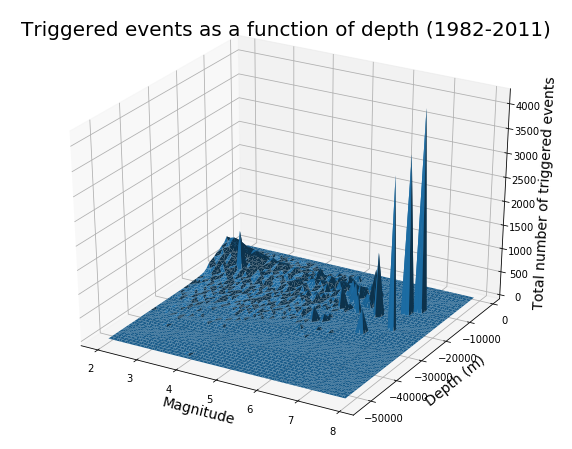

In [8]:
interval_mag = np.arange(2,8.1,0.1)  # Create the intervals of magnitude
interval_dep = np.arange(df['depth'].min(),df['depth'].max()+1000,1000)  # Create the intervals of depth
number = []
x_grid = []
y_grid = []

for j in range(interval_mag.shape[0]-1): # Counting in interval of magnitude 
    for i in range(interval_dep.shape[0]-1): # Counting in interval of depth
        df_m = df[np.logical_and(df['magnitude']>=interval_mag[j], df['magnitude']<interval_mag[j+1])]
        df_d = df_m[np.logical_and(df_m['depth']>=interval_dep[i], df_m['depth']<interval_dep[i+1])]
        number.append(df_d['num_trig'].sum())
        x_grid.append(interval_mag[j])
        y_grid.append(interval_dep[i])
        
fig = plt.figure(figsize=(10, 8))
ax = plt.axes(projection='3d')
ax.set_xlabel('Magnitude', fontsize=14)
ax.set_ylabel('Depth (m)', fontsize=14)
ax.set_zlabel('Total number of triggered events', fontsize=14)
ax.set_title("Triggered events as a function of depth (1982-2011)", fontsize=20)
ax.plot_trisurf(x_grid, y_grid, number,linewidth=0.1)

### 2.2 - Plot of magnitude per month <a class="anchor" id="2.2"></a>
* [Index](#0)

We produce an interactive plot of the magnitude of each earthquake in a given month and year.

In [9]:
# Fix the years and month of start and end of the animation
START_YEAR = 1982
END_YEAR = 2011
START_MONTH = 1
END_MONTH = 12

# Setting the first frame
m_max = df['magnitude'].max()
m_min = df['magnitude'].min()
points_slider = df[df['year']==START_YEAR] # Filter the dataframe for the starting year and month
 
x_slider, y_slider = list(points_slider['month']), list(points_slider['magnitude']) # Select the longitude and magnitude column
plt.close()

df_slider = df

def update1(year_slider): # Update the plot for the selected year
    plt.figure(figsize=(10, 8))
    plt.ylim((m_min-0.1,m_max+0.1))
    plt.xlim(0,13)
    plt.xticks([i for i in range(1,13)])
    current_year = year_slider
    points_slider = df_slider[df_slider['year']==current_year]
    x_slider, y_slider = list(points_slider['month']), list(points_slider['magnitude'])
    plt.title("Magnitude earthquake visualisation ("+str(START_YEAR)+'-'+str(END_YEAR)+')', fontsize=20)
    plt.xlabel('Month', fontsize=14)
    plt.ylabel('Magnitude', fontsize=14)
    plt.plot(x_slider,y_slider,'.',color='red')
    fig.canvas.draw_idle()

anim = interact(update1, year_slider = widgets.IntSlider(value=1992, min=START_YEAR, max=END_YEAR, step=1));

anim

interactive(children=(IntSlider(value=1992, description='year_slider', max=2011, min=1982), Output()), _dom_cl…

<function __main__.update1(year_slider)>

### 2.3 - Visualization in space and time <a class="anchor" id="2.3"></a>
* [Index](#0)

Eventually, we create an animation to visualize in space and time earthquakes plotted on a 2D map. In each frame we represent all earthquakes happened in a fixed month and year with a scatter plot where color of the dots represents depth and its size represents the magnitude. 

In [10]:
# CREATE THE ANIMATION
fig = plt.figure(figsize=(12, 10))
ax = plt.axes(projection=ccrs.PlateCarree())

# Formatting axes ticks
ax.set_xticks([-114, -116, -118, -120, -122, -124], crs=ccrs.PlateCarree())
ax.set_yticks([30, 32, 34, 36, 38], crs=ccrs.PlateCarree())
lon_formatter = LongitudeFormatter(zero_direction_label=True)
lat_formatter = LatitudeFormatter()
ax.xaxis.set_major_formatter(lon_formatter)
ax.yaxis.set_major_formatter(lat_formatter)
extent = [-125.97, -111.95, 28.62, 38.41]
ax.set_extent(extent)

# Downloading background from Stamen Maps 
stamen_terrain = cimgt.Stamen('terrain-background')
ax.add_image(stamen_terrain, 7)   
  
# Plot the position of some cities on the map
plt.plot(-122.4194200,  37.7749300, '+', ms=8, color = 'black') # San Francisco position
SFlabel = plt.text(-124, 38, 'San Francisco', fontsize=12, color='black')
plt.plot(-115.172813, 36.114647, '+', ms=8, color = 'black')  # Las Vegas position
SFlabel = plt.text(-114.8, 36.2, 'Las Vegas', fontsize=12, color='black')
plt.plot(-112.074036, 33.448376, '+', ms=8, color = 'black') # Phoenix position
SFlabel = plt.text(-113.2, 33.6, 'Phoenix', fontsize=12, color='black')
plt.plot(-118.243683, 34.052235, '+', ms=8, color = 'black')  # Los Angeles position
SFlabel = plt.text(-120.1, 33.8, 'Los Angeles', fontsize=12, color='black')  

# Fix the years and month of start and end of the animation
START_YEAR = 1982
END_YEAR = 2011
START_MONTH = 1
END_MONTH = 12

# Setting the first frame
# Filter the dataframe for the starting year and month
points = df[df['year']==START_YEAR]
points = points[points['month']==START_MONTH]
x, y = list(points['longitude']), list(points['latitude']) # Select the longitude and magnitude column
mag = np.array((np.exp(1.15*points['magnitude']))) # Select the magnitude column passing the exponent of the value for highilighting the difference
color = np.array(points['depth']/1000.) # Select the depth column expressing it in km

# Create the scatter plot, where the magntitude scales as the radius and the depth as the color 
scat = plt.scatter(x, y, s = mag,  marker='o', alpha=0.7, c=color, cmap='hot', vmin=df['depth'].min()/1000.0, vmax=df['depth'].max()/1000.0)  

# Create legend of the magntitude
for magn in [2, 3, 4, 5, 6]:
    plt.scatter([], [], c='black', alpha=0.7, s=np.exp(1.15*magn), label=str(magn))   
leg = plt.legend(scatterpoints=1, frameon=False, labelspacing=2, title='Magnitude', loc="upper left")
plt.setp(leg.get_title(), color='black', fontsize=12)
plt.setp(leg.get_texts(), color='black')

# Create legend of the depth
cbar = plt.colorbar(scat, shrink = 0.9)
cbar.set_label('Depth [km]', fontsize=14)

plt.title("Earthquake visualisation ("+str(START_YEAR)+'-'+str(END_YEAR)+')', fontsize=20) #title
year_text = plt.text(-125.5, 29., str(START_MONTH)+'-'+str(START_YEAR), fontsize=30, color='black') #month and year of the frame
plt.axis(aspect='equal')
plt.xlabel('Longitude', fontsize=14)
plt.ylabel('Latitude', fontsize=14)
plt.close()

def update(frame_number): # Update the plot for increasing year and month
    current_year = START_YEAR + int(((frame_number/12) % (END_YEAR - START_YEAR + 1)))
    current_month = START_MONTH + (frame_number % 12)
    year_text.set_text(str(current_month)+'-'+str(current_year)) 
    points = df[df['year']==current_year]
    points = points[points['month']==current_month]
    x, y = list(points['longitude']), list(points['latitude'])
    mag = np.array( (np.exp(1.15*points['magnitude'])) )
    color = np.array(points['depth']/1000.)
    scat.set_offsets(np.c_[x,y]) 
    scat.set_sizes(mag)
    scat.set_array(color)
    
'''ani = animation.FuncAnimation(fig, update, interval=0.0001, frames=12*(END_YEAR - START_YEAR +1))
ani.save('animation.gif', writer='imagemagick', fps=3)    
filename = 'animation.gif'
video = io.open(filename, 'r+b').read()
encoded = base64.b64encode(video)'''
#HTML(data='''<img src="data:image/gif;base64,{0}" type="gif" />'''.format(encoded.decode('ascii')))

"ani = animation.FuncAnimation(fig, update, interval=0.0001, frames=12*(END_YEAR - START_YEAR +1))\nani.save('animation.gif', writer='imagemagick', fps=3)    \nfilename = 'animation.gif'\nvideo = io.open(filename, 'r+b').read()\nencoded = base64.b64encode(video)"

## Power Law Distribution

Seismicity is a complex spatiotemporal phenomenon which obeys certain simple general laws that govern the statistics of their occurence. In particular, waiting time and distance of earthquakes is expected to follow a power law distribution:

$$ P(t) = C t^{- \alpha} $$

A power law distribuion is visualized as a straight line on a log-log plot:

$$ \ln P(t) = \ln C - \alpha \ln t $$

## 3 - Distribution of waiting time $P_m(t)$ <a class="anchor" id="3"></a>
* [Index](#0)

We compute the distribution of waiting time for earthquakes of magnitude m or above for m in [2,5]. For a fixed m we compute the waiting time as the difference between the time of an event and the next one. 

In [11]:
# Read data from file and make sure earthquakes are ordered by time
cols = ['index', 'trigger', 'time', 'magnitude', 'X', 'Y', 'Z']
df = pd.read_table("SouthCalifornia-1982-2011_Physics-of-Data.dat",sep=" ",header=None)
df.columns = cols
df = df.sort_values(by = ['time'])

m = 3 # Set lower bound to magnitude

df_red = copy.deepcopy(df[df['magnitude']>=m]) # Filter earthquakes with magnitude m o above

print("Number of selected earthquakes: ", df_red.shape[0])

df_red['waiting'] = np.abs(df_red['time'].diff(periods=-1)) # Compute the waiting time 
df_red = df_red.dropna()

Number of selected earthquakes:  11923


### 3.1 - Histogram with regular binning <a class="anchor" id="3.1"></a>
* [Index](#0)

First of all we plot the histogram of normalized frequency vs waiting time using a fixed binning proportional to the $\sqrt{N}$ where $N$ is the number of total events.

Text(0, 0.5, 'Normalized Frequency')

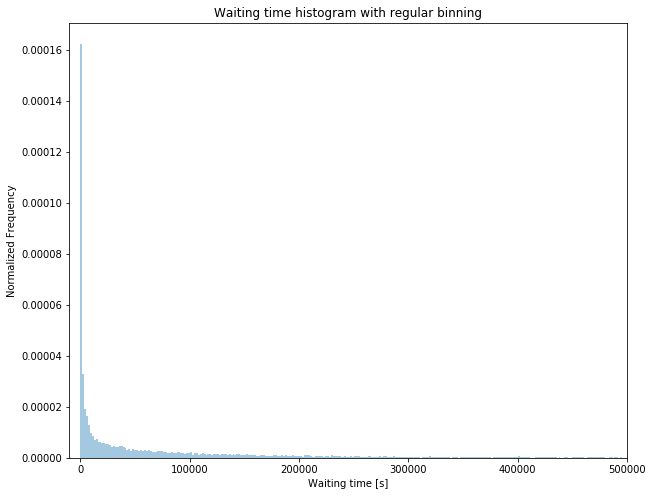

In [12]:
# Plot a normalized histogram
fig, ax = plt.subplots(figsize=(10,8))
ax = sns.distplot(df_red['waiting'], bins=10*int(np.sqrt(df_red.shape[0])), kde=False, norm_hist=True)
ax.set_xlim(-10000,500000)
ax.set_title('Waiting time histogram with regular binning')
ax.set_xlabel('Waiting time [s]')
ax.set_ylabel('Normalized Frequency')

In order to improve visualization, we plot the dotted histogram in log-log scale. We notice some noise in the tail of the distribution due to the low number of entries in that region. The result is that we have more information on the part of the distribution we care the less. As said, assuming power law behaviour, we should perform a linear regression on data in log-log scale histogram to extrapulate the parameter of the distribution. However, the noise introduce a bias on the slope. In order to erase the noise, we need to enlarge bin size in the tail of the distribution. Usually a logarithmic binnins is used for this scope. 

Text(0, 0.5, 'Normalized Frequency')

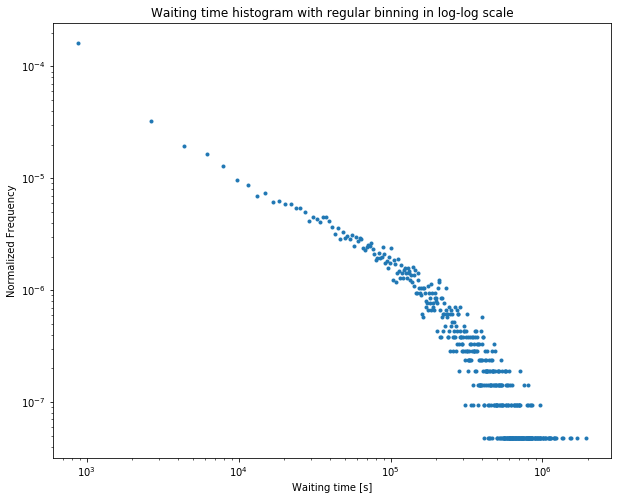

In [13]:
# Copy data from histogram to produce a dotted histogram
width = np.array([h.get_width() for h in ax.patches]) 
edge = np.array([h.get_xy()[0] for h in ax.patches]) # Left edges
x = np.add(edge,width/2.) # Center of bins
y = [h.get_height() for h in ax.patches] # Frequency of data 

fig = plt.subplots(figsize=(10,8))
plt.plot(x,y,'.')
plt.xscale('log')
plt.yscale('log')
plt.title('Waiting time histogram with regular binning in log-log scale')
plt.xlabel('Waiting time [s]')
plt.ylabel('Normalized Frequency')

### 3.2 - Histogram with logarithmic binning <a class="anchor" id="3.2"></a>
* [Index](#0)

We compute the histogram with logarithmic binning and we observe in the dotted log-log scale histogram that the noise has been removed. Now the information is more uniformly distributed among bins.

Text(0, 0.5, 'Normalized Frequency')

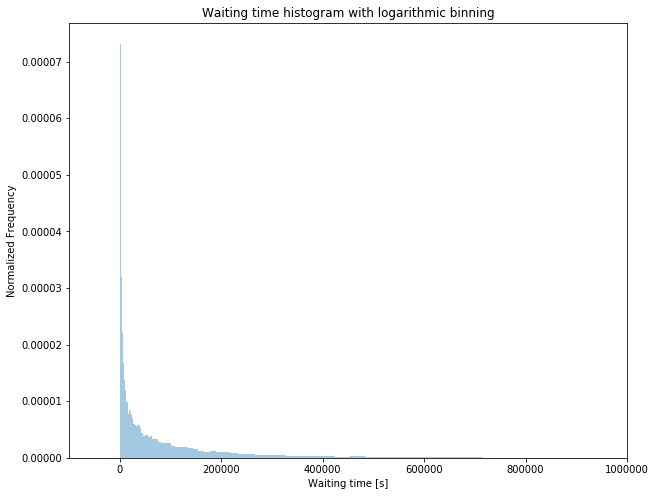

In [14]:
# Set logarithmic binning

width = 1000*np.logspace(0, 3, int(np.sqrt(df_red.shape[0]))+1)
edge = np.cumsum(width) # Compute the right edges

# Histogram with logarithmic binning
ax1 = sns.distplot(df_red['waiting'], bins=edge, kde=False) # Non-normalized plot used to compute errors
plt.close()
fig, ax = plt.subplots(figsize=(10,8))
ax = sns.distplot(df_red['waiting'], bins=edge, kde=False, norm_hist=True) # Plot a normalized histogram

ax.set_xlim(-100000,1000000)
ax.set_title('Waiting time histogram with logarithmic binning')
ax.set_xlabel('Waiting time [s]')
ax.set_ylabel('Normalized Frequency')

We notice a bending in the distibution which suggests that the head of the distribution behaves as a power law while the tail decays more rapidly (i.e. as an exponential) since events with large waiting times are less likely to happen. This can be attributed to the fact that earthquake events happening at very large distances away from each other are less likely to be correlated, and are thus generated by random, independent process.

Text(0, 0.5, 'Normalized Frequency')

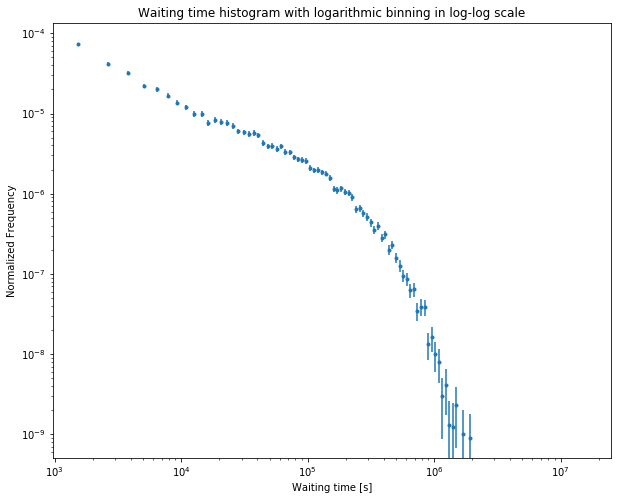

In [15]:
# Compute the error of the bin as a Poissonian
width = np.array([h.get_width() for h in ax1.patches])
y1 = np.array([h.get_height() for h in ax1.patches]) # Frequency of data 
y_error = np.divide(np.sqrt(y1),np.sum(y1)*width)

# Copy data from histogram to produce a dot histogram
width = np.array([h.get_width() for h in ax.patches]) 
edge = np.array([h.get_xy()[0] for h in ax.patches]) # Left edges
x = np.add(edge,width/2.) # Center of bins
y = [h.get_height() for h in ax.patches] # Frequency of data 

fig = plt.subplots(figsize=(10,8))
plt.errorbar(x, y,yerr=y_error,fmt='.')
plt.xscale('log')
plt.yscale('log')
plt.title('Waiting time histogram with logarithmic binning in log-log scale')
plt.xlabel('Waiting time [s]')
plt.ylabel('Normalized Frequency')

### 3.3 - Linear regression with tuning of lower cutoff <a class="anchor" id="3.3"></a>
* [Index](#0)

In order to estimate the exponent of the power law decay we need to consider only the linear part of the distribution. Hence, we fix a lower bound to stop at the last bin before the bending begin. 
We consider the set of arrays each containing the points of the histogram from the first to the i-th with i that goes from the first to the last point. The i-th point corresponds to the lower bound. We perform linear regression for each of these arrays and we plot the slope vs the lower bound of the fitted array. Eventually we choose as lower bound a point in the region of stability of the value of the slope.

Text(0, 0.5, 'Slope [s$^{-1}$]')

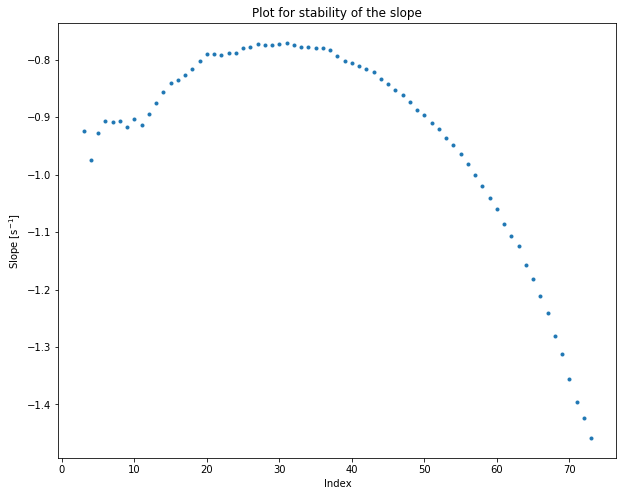

In [16]:
# Compute vectors with logarithm of frequences and centers of edges in order to perform linear regression
xy = pd.DataFrame({'x':x, 'y':y})
xy = xy[ xy.y != 0 ] # Drop bin with zero frequency in order to compute the logarithm
x_reg = np.log10(np.array(xy.x))
y_reg = np.log10(np.array(xy.y))

alpha = []
x_part = []

for i in range(3,len(x_reg)): # Perfom linear regression after removing elements from x_m to the end of the vector
    x_prov = x_reg[:i]
    y_prov = y_reg[:i]
    model = LinearRegression().fit(x_prov.reshape(-1,1), y_prov.reshape(-1,1))
    alpha.append(model.coef_[0][0])
    x_part.append(i)

fig = plt.subplots(figsize=(10,8))
plt.plot(x_part,alpha,'.')
plt.title('Plot for stability of the slope')
plt.xlabel('Index')
plt.ylabel('Slope [s$^{-1}$]')

Once we chose the lower bound, we perform linear regression and we observe values of the slope, for all m, in a range between about 0.65 and 1, which are similar to values we found in litterature.

Intercept: [-1.84185214]
Slope: [[-0.75537096]]


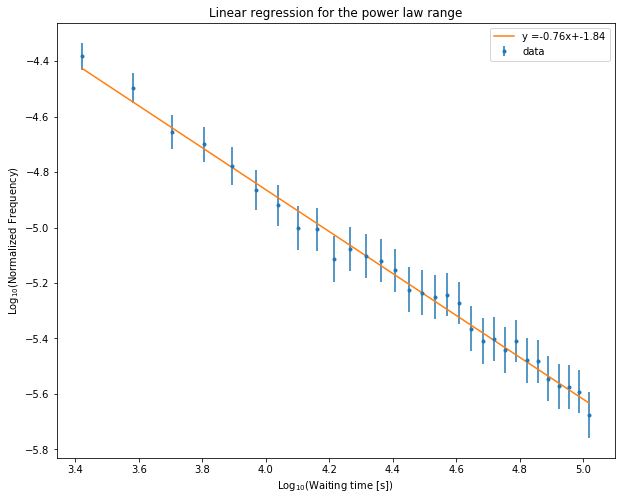

In [17]:
# Choose best lower bound
slope = []
chosen_index = []

for i in range(len(x_part)-10): # Compute the slope for a set of 10 consecutive points
    x_set = np.array(x_part[i:i+10])
    y_set = np.array(alpha[i:i+10])
    model = LinearRegression().fit(x_set.reshape(-1,1), y_set.reshape(-1,1))
    chosen_index.append(i+10)
    slope.append(model.coef_[0][0])

data_tuples = list(zip(chosen_index,slope))
g = pd.DataFrame(data_tuples,columns=['x_min_index','slope'])
g['slope'] = np.abs(g['slope'])
x_min_index =  np.array(g.loc[g['slope'] == g['slope'].min()]) # Choose the last point of the set as lower bound

# Perform linear regression with the best value x_min
x_corr = np.array(x_reg[1:int(x_min_index[0][0])])
y_corr = np.array(y_reg[1:int(x_min_index[0][0])])

model = LinearRegression().fit(x_corr.reshape(-1,1), y_corr.reshape(-1,1))

print('Intercept:', model.intercept_)
print('Slope:', model.coef_)

y_error_corr = np.divide(y_error[1:int(x_min_index[0][0])],y[1:int(x_min_index[0][0])]) # Compute errors

# Plot fit
l = np.linspace(x_corr.min(), x_corr.max(),len(x_corr))

fig = plt.subplots(figsize=(10,8))
plt.errorbar(x_corr, y_corr,yerr=y_error_corr,fmt='.')
plt.plot(l, model.intercept_[0] + model.coef_[0][0]*l)
plt.title('Linear regression for the power law range')
plt.xlabel('Log$_{10}$(Waiting time [s])')
plt.ylabel('Log$_{10}$(Normalized Frequency)')
plt.legend(('y ={0:01.2f}x{1:01.2f}'.format(model.coef_[0][0],model.intercept_[0]),'data'))
plt.show()

### 3.4 - Analysis for different values of $m$ <a class="anchor" id="3.4"></a>
* [Index](#0)

Eventually we perform this analysis for different values of $m$ and show the result in the same plot for comparison. 

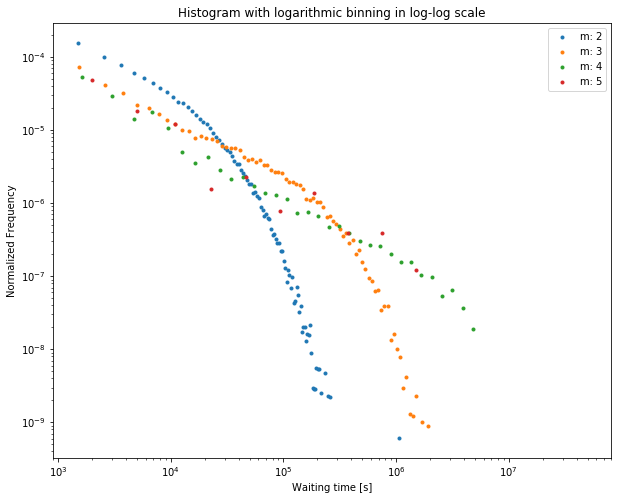

In [18]:
mag = [2,3,4,5] # Set the value of m
xx_waiting = [0,0,0,0]
yy_waiting = [0,0,0,0]
w_mean = [0,0,0,0]

for i in range(len(mag)): # Repeat the analysis for m in mag
    df_red = copy.deepcopy(df[df['magnitude'] >= mag[i]])
    df_red['waiting'] = np.abs(df_red['time'].diff(periods=-1)) # Compute the waiting time 
    df_red = df_red.dropna()
    w_mean[i] = df_red['waiting'].mean()
    width = 1000*np.logspace(0, 3, int(np.sqrt(df_red.shape[0]))+1)
    edge = np.cumsum(width)
    fig, ax = plt.subplots(figsize=(10,8))
    ax = sns.distplot(df_red['waiting'], bins = edge, kde=False, norm_hist=True)
    edge = np.array([h.get_xy()[0] for h in ax.patches])# Left edges
    width = np.array([h.get_width() for h in ax.patches])
    xx_waiting[i] = np.add(edge, width/2.)  # Center of bins
    yy_waiting[i] = np.array([h.get_height() for h in ax.patches]) # Frequency of data 
    plt.close()

# Plot for all m in log-log scale
fig = plt.subplots(figsize=(10,8))
for i in range(len(mag)):
    plt.plot(xx_waiting[i],yy_waiting[i],'.',label="m: {}".format(i+2))
plt.xscale('log')
plt.yscale('log')
plt.title('Histogram with logarithmic binning in log-log scale')
plt.xlabel('Waiting time [s]')
plt.ylabel('Normalized Frequency')
plt.legend()
plt.show()

## 4 - Distribution of distances $P_m(r)$ <a class="anchor" id="4"></a>
* [Index](#0)

We compute the distribution $P_m(r)$ of the distance, in Euclidian coordinates, between hypocenters of an event and the next one, in time,  considering earthquakes of magnitude m or above. Since we assume that distances are distributed as power law as well, we repeat the whole procedure. Again we plot results for different values of $m$ in the same plot. 

In [19]:
# Read data from file and make sure earthquakes are ordered by time
cols = ['index', 'trigger', 'time', 'magnitude', 'X', 'Y', 'Z']
df = pd.read_table("SouthCalifornia-1982-2011_Physics-of-Data.dat",sep=" ",header=None)
df.columns = cols
df = df.sort_values(by = ['time'])

m = 3 # Set lower bound to magnitude

df_red = copy.deepcopy(df[df['magnitude']>=m]) # Filter earthquakes with magnitude m o above

print("Number of selected earthquakes: ", df_red.shape[0])

df_red['distance'] = np.sqrt((df_red['X'].diff(periods=-1))**2 + (df_red['Y'].diff(periods=-1))**2 + (df_red['Z'].diff(periods=-1))**2)
df_red = df_red.dropna()

Number of selected earthquakes:  11923


### 4.1 - Histogram with regular binning <a class="anchor" id="4.1"></a>
* [Index](#0)

Text(0, 0.5, 'Normalized frequency')

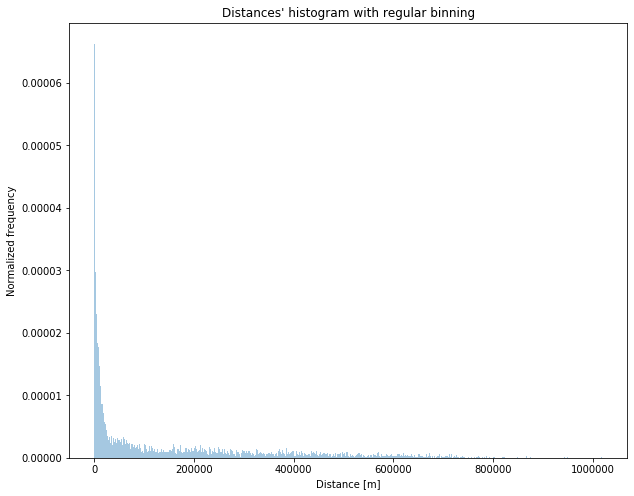

In [20]:
# Plot a normalized histogram
fig, ax = plt.subplots(figsize=(10,8))
ax = sns.distplot(df_red['distance'], bins=10*int(np.sqrt(df_red.shape[0])), kde=False, norm_hist=True)
ax.set_title("Distances' histogram with regular binning")
ax.set_xlabel('Distance [m]')
ax.set_ylabel('Normalized frequency')

Text(0, 0.5, 'Normalized frequency')

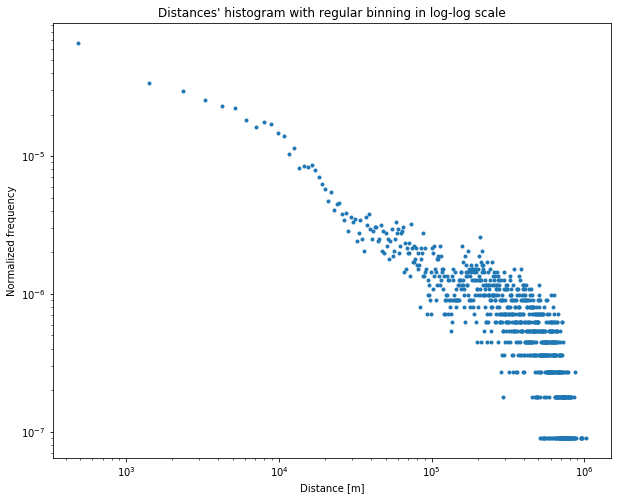

In [21]:
# Copy data from histogram to produce a dot histogram
width = np.array([h.get_width() for h in ax.patches]) 
edge = np.array([h.get_xy()[0] for h in ax.patches]) # Left edges
x = np.add(edge,width/2.) # Center of bins
y = [h.get_height() for h in ax.patches] # Frequency of data 

fig = plt.subplots(figsize=(10,8))
plt.plot(x,y,'.')
plt.xscale('log')
plt.yscale('log')
plt.title("Distances' histogram with regular binning in log-log scale")
plt.xlabel('Distance [m]')
plt.ylabel('Normalized frequency')

### 4.2 - Histogram with logarithmic binning <a class="anchor" id="4.2"></a>
* [Index](#0)

Text(0, 0.5, 'Normalized frequency')

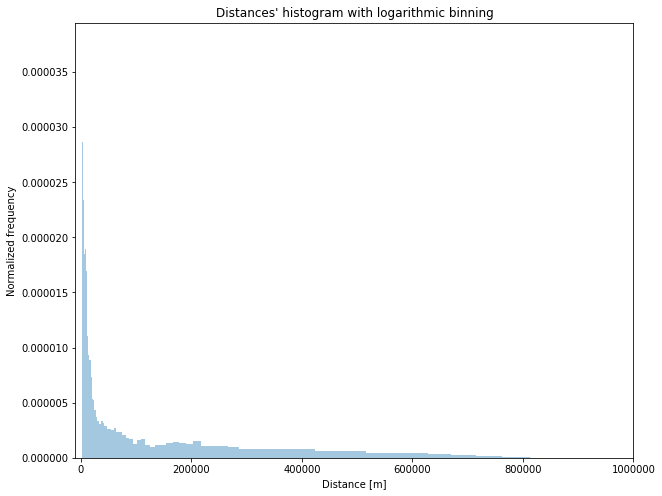

In [22]:
# Set logarithmic binning

width = 1000*np.logspace(0, 3, int(np.sqrt(df_red.shape[0]))+1)
edge = np.cumsum(width) # Compute the right edges

# Histogram with logarithmic binning
ax1 = sns.distplot(df_red['distance'], bins=edge, kde=False) # Non-normalized plot used to compute errors
plt.close()
fig, ax = plt.subplots(figsize=(10,8))
ax = sns.distplot(df_red['distance'], bins=edge, kde=False, norm_hist=True) # Plot a normalized histogram

ax.set_xlim(-10000,1000000)
ax.set_title("Distances' histogram with logarithmic binning")
ax.set_xlabel('Distance [m]')
ax.set_ylabel('Normalized frequency')

Text(0, 0.5, 'Normalized frequency')

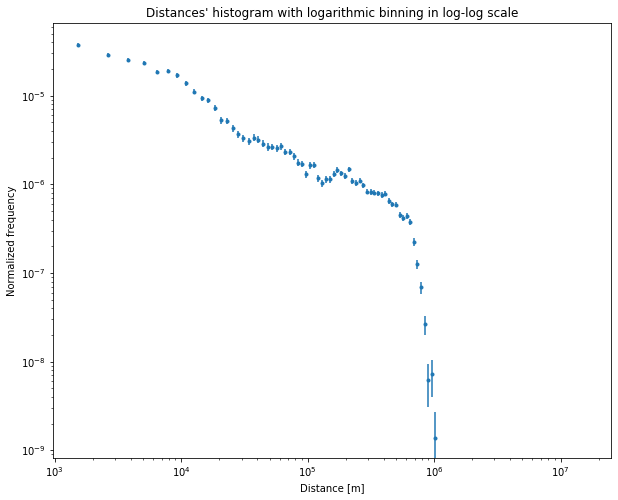

In [23]:
# Compute the error of the bin as a Poissonian
width = np.array([h.get_width() for h in ax1.patches])
y1 = np.array([h.get_height() for h in ax1.patches]) # Frequency of data 
y_error = np.divide(np.sqrt(y1),np.sum(y1)*width)

# Copy data from histogram to produce a dot histogram
width = np.array([h.get_width() for h in ax.patches]) 
edge = np.array([h.get_xy()[0] for h in ax.patches]) # Left edges
x = np.add(edge,width/2.) # Center of bins
y = [h.get_height() for h in ax.patches] # Frequency of data 

fig = plt.subplots(figsize=(10,8))
plt.errorbar(x, y,yerr=y_error,fmt='.')
plt.xscale('log')
plt.yscale('log')
plt.title("Distances' histogram with logarithmic binning in log-log scale")
plt.xlabel('Distance [m]')
plt.ylabel('Normalized frequency')

### 4.3 - Linear regression with tuning of lower cutoff <a class="anchor" id="4.3"></a>
* [Index](#0)

Text(0, 0.5, 'Slope [m$^{-1}$]')

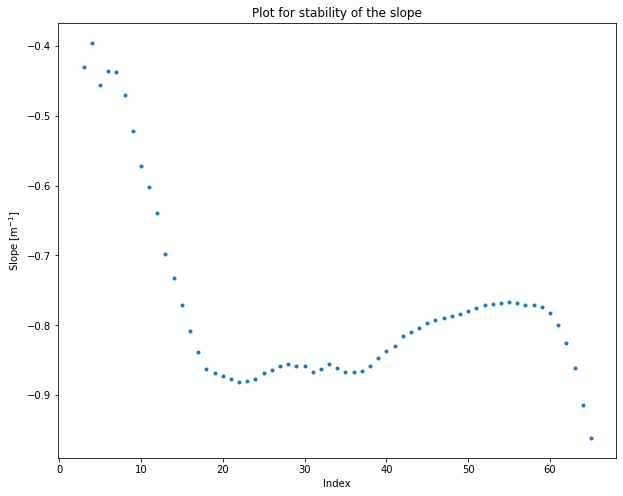

In [24]:
# Compute vectors with logarithm of frequences and centers of edges in order to perform linear regression
xy = pd.DataFrame({'x':x, 'y':y})
xy = xy[ xy.y != 0 ] # Drop bin with zero frequency in order to compute the logarithm
x_reg = np.log10(np.array(xy.x))
y_reg = np.log10(np.array(xy.y))

# Perfom linear regression after removing elements from x_m to the end of the vector
alpha = []
x_part = []

for i in range(3,len(x_reg)):
    x_prov = x_reg[:i]
    y_prov = y_reg[:i]
    model = LinearRegression().fit(x_prov.reshape(-1,1), y_prov.reshape(-1,1))
    alpha.append(model.coef_[0][0])
    x_part.append(i)

fig = plt.subplots(figsize=(10,8))
plt.plot(x_part,alpha,'.')
plt.title('Plot for stability of the slope')
plt.xlabel('Index')
plt.ylabel('Slope [m$^{-1}$]')

Intercept: [-1.36211278]
Slope: [[-0.89118091]]


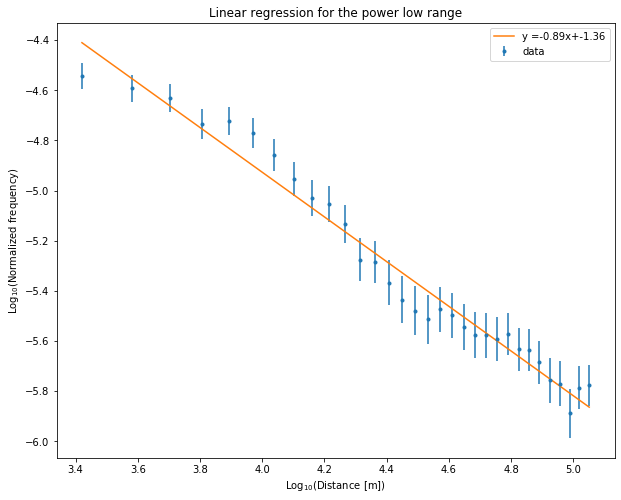

In [25]:
# Choose best lower bound
slope = []
chosen_index = []

for i in range(len(x_part)-5): # Compute the slope for al consecutive set of five points
    x_set = np.array(x_part[i:i+5])
    y_set = np.array(alpha[i:i+5])
    model = LinearRegression().fit(x_set.reshape(-1,1), y_set.reshape(-1,1))
    chosen_index.append(i+5)
    slope.append(model.coef_[0][0])

data_tuples = list(zip(chosen_index,slope))
g = pd.DataFrame(data_tuples,columns=['x_min_index','slope'])
g['slope'] = np.abs(g['slope'])
x_min_index =  np.array(g.loc[g['slope'] == g['slope'].min()]) # Choose the last point of the set with lower bound

# Perform linear regression with the best value x_min
x_corr = np.array(x_reg[1:int(x_min_index[0][0])])
y_corr = np.array(y_reg[1:int(x_min_index[0][0])])

model = LinearRegression().fit(x_corr.reshape(-1,1), y_corr.reshape(-1,1))

print('Intercept:', model.intercept_)
print('Slope:', model.coef_)

y_error_corr = np.divide(y_error[1:int(x_min_index[0][0])],y[1:int(x_min_index[0][0])]) # Compute errors

# Plot fit
l = np.linspace(x_corr.min(), x_corr.max(),len(x_corr))

fig = plt.subplots(figsize=(10,8))
plt.errorbar(x_corr, y_corr,yerr=y_error_corr,fmt='.')
plt.plot(l, model.intercept_[0] + model.coef_[0][0]*l)
plt.title('Linear regression for the power low range')
plt.xlabel('Log$_{10}$(Distance [m])')
plt.ylabel('Log$_{10}$(Normalized frequency)')
plt.legend(('y ={0:01.2f}x{1:01.2f}'.format(model.coef_[0][0],model.intercept_[0]),'data'))
plt.show()

### 4.4 - Analysis for different values of $m$ <a class="anchor" id="4.4"></a>
* [Index](#0)

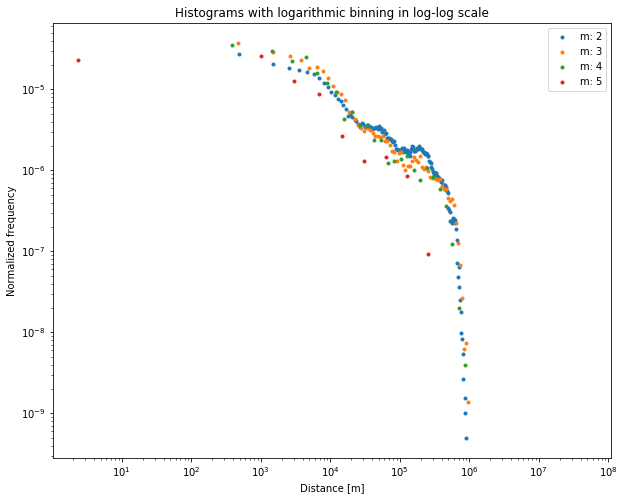

In [26]:
mag = [2,3,4,5] # Set varius the value of m
xx_dist = [0,0,0,0]
yy_dist = [0,0,0,0]
mean = [0,0,0,0]
max_dist = [0,0,0,0]

for i in range(len(mag)):
    df_red = copy.deepcopy(df[df['magnitude'] >= mag[i]])
    df_red['distance'] = np.sqrt((df_red['X'].diff(periods=-1))**2 + (df_red['Y'].diff(periods=-1))**2 + 
                                 (df_red['Z'].diff(periods=-1))**2)
    df_red = df_red.dropna()
    max_dist[i] = df_red['distance'].max()
    width = 1000*np.logspace(0, 3, int(np.sqrt(df_red.shape[0]))+1)
    edge = np.cumsum(width)
    fig, ax = plt.subplots(figsize=(10,8))
    ax = sns.distplot(df_red['distance'], bins = edge, kde=False, norm_hist=True)
    edge = np.array([h.get_xy()[0] for h in ax.patches]) 
    width = np.array([h.get_width() for h in ax.patches])
    xx_dist[i] = np.add(edge, -width/2.)
    yy_dist[i] = np.array([h.get_height() for h in ax.patches])
    plt.close()

# Plot for all m in log-log scale

fig = plt.subplots(figsize=(10,8))

for i in range(len(mag)):
    plt.plot(xx_dist[i],yy_dist[i],'.',label="m: {}".format(i+2))

plt.xscale('log')
plt.yscale('log')
plt.title('Histograms with logarithmic binning in log-log scale')
plt.xlabel('Distance [m]')
plt.ylabel('Normalized frequency')
plt.legend()
plt.show()

## 5 - Distribution of waiting time below a certain distance $P_{m,R}(t)$ <a class="anchor" id="5"></a>
* [Index](#0)

We compute the distribution $P_{m,R}(t)$ of waiting times for events of magnitude $m$ or above, which are separated by at most a distance $r<R$, for different values of m and $R$: this conditional distributions of earthquake return waiting times subject to the corresponding spatial separation.


We perform a similar analysis as above for $m$ in [2,3,4,5] and $R$ in $[R^* /2, R^*,2R^*]$ where $R^*$ is the mean value of the distance for a fixed $m$.

In [27]:
# Read data from file and make sure earthquakes are ordered by time
cols = ['index', 'trigger', 'time', 'magnitude', 'X', 'Y', 'Z']
df = pd.read_table("SouthCalifornia-1982-2011_Physics-of-Data.dat",sep=" ",header=None)
df.columns = cols
df = df.sort_values(by = ['time'])

m = 3 # Set lower bound to magnitude

df_m = copy.deepcopy(df[df['magnitude'] >= m]) # Filter earthquakes with magnitude m o above

print("Number of selected earthquakes: ", df_m.shape[0])

df_m['distance'] = np.sqrt(( df_m['X'].diff(periods=-1) )**2+( df_m['Y'].diff(periods=-1) )**2+
                           ( df_m['Z'].diff(periods=-1) )**2)
df_m = df_m.dropna()

r = df_m['distance'].mean() # Set upper bound to distances
df_r = copy.deepcopy(df_m[df_m['distance']<r])

# Compute the waiting time and and set the first waiting time to 0
df_r['waiting'] = np.abs(df_r['time'].diff(periods=-1)) # Compute the waiting time 
df_r = df_r.dropna()
df_red = copy.deepcopy(df_r)

Number of selected earthquakes:  11923


### 5.1 - Histogram with regular binning <a class="anchor" id="5.1"></a>
* [Index](#0)

Text(0, 0.5, 'Normalized frequency')

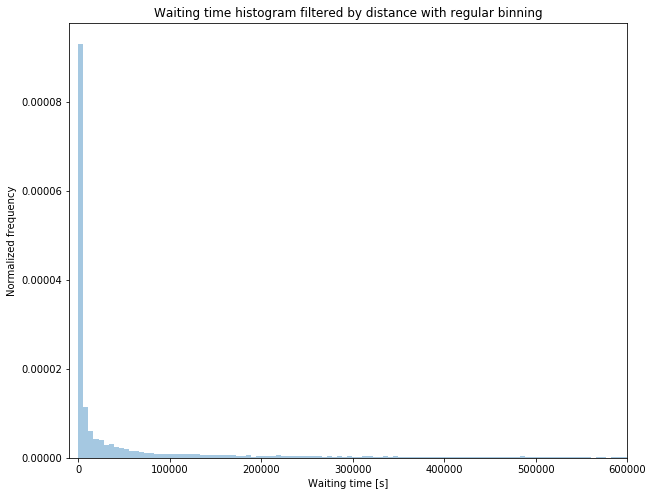

In [28]:
# Plot a normalized histogram
fig, ax = plt.subplots(figsize=(10,8))
ax = sns.distplot(df_red['waiting'], bins=10*int(np.sqrt(df_red.shape[0])), kde=False, norm_hist=True)
ax.set_xlim(-10000,600000)
ax.set_title('Waiting time histogram filtered by distance with regular binning')
ax.set_xlabel('Waiting time [s]')
ax.set_ylabel('Normalized frequency')

Text(0, 0.5, 'Normalized frequency')

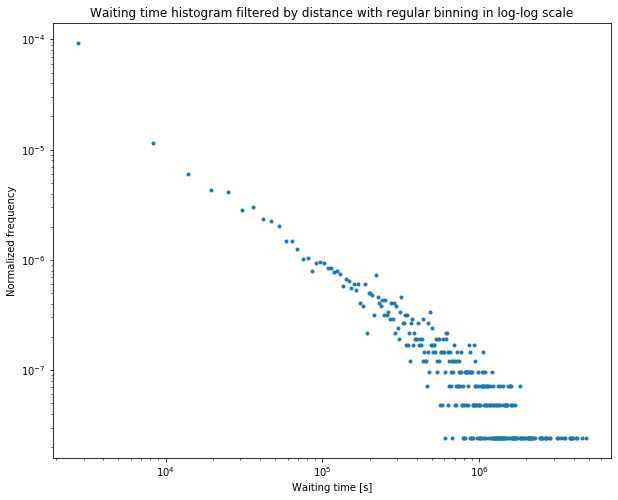

In [29]:
# Copy data from histogram to produce a dot histogram
width = np.array([h.get_width() for h in ax.patches]) 
edge = np.array([h.get_xy()[0] for h in ax.patches]) # Left edges
x = np.add(edge,width/2.) # Center of bins
y = [h.get_height() for h in ax.patches] # Frequency of data 

fig = plt.subplots(figsize=(10,8))
plt.plot(x,y,'.')
plt.xscale('log')
plt.yscale('log')
plt.title('Waiting time histogram filtered by distance with regular binning in log-log scale')
plt.xlabel('Waiting time [s]')
plt.ylabel('Normalized frequency')

### 5.2 - Histogram with logarithmic binning <a class="anchor" id="5.2"></a>
* [Index](#0)

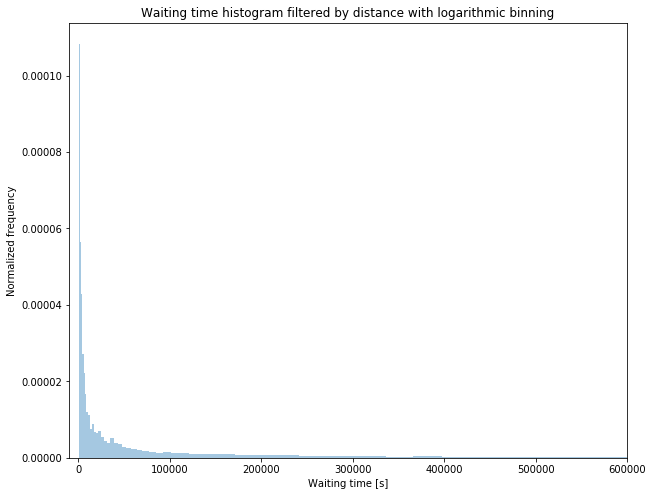

In [30]:
# Set logarithmic binning

width = 1000*np.logspace(0, 3, int(np.sqrt(df_red.shape[0]))+1)
edge = np.cumsum(width) # Compute the right edges

# Histogram with logarithmic binning
ax1 = sns.distplot(df_red['waiting'], bins=edge, kde=False) # Non-normalized plot used to compute errors
plt.close()
fig, ax = plt.subplots(figsize=(10,8))
ax = sns.distplot(df_red['waiting'], bins=edge, kde=False, norm_hist=True) # Plot a normalized histogram

ax.set_xlim(-10000,600000)
ax.set_title('Waiting time histogram filtered by distance with logarithmic binning')
ax.set_xlabel('Waiting time [s]')
ax.set_ylabel('Normalized frequency')

plt.show()

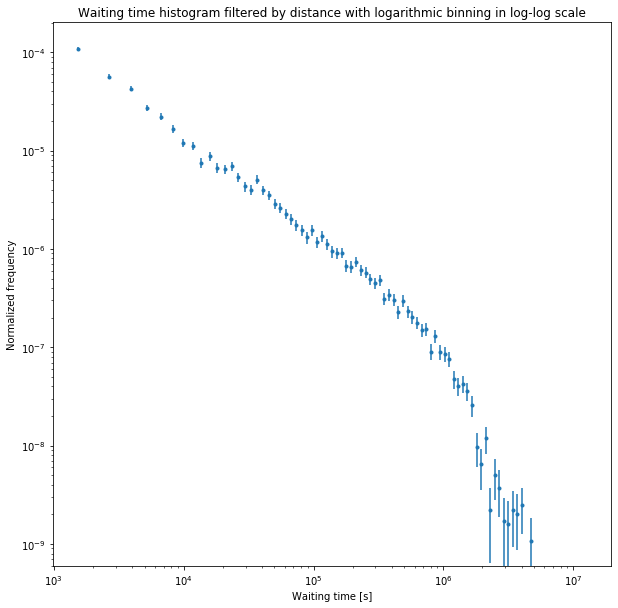

In [31]:
# Compute the error of the bin as a Poissonian
width = np.array([h.get_width() for h in ax1.patches])
y1 = np.array([h.get_height() for h in ax1.patches]) # Frequency of data 
y_error = np.divide(np.sqrt(y1),np.sum(y1)*width)

# Copy data from histogram to produce a dot histogram
width = np.array([h.get_width() for h in ax.patches]) 
edge = np.array([h.get_xy()[0] for h in ax.patches]) # Left edges
x = np.add(edge,width/2.) # Center of bins
y = [h.get_height() for h in ax.patches] # Frequency of data 

fig = plt.subplots(figsize=(10,10))
plt.errorbar(x, y,yerr=y_error,fmt='.')
plt.xscale('log')
plt.yscale('log')
plt.title('Waiting time histogram filtered by distance with logarithmic binning in log-log scale')
plt.xlabel('Waiting time [s]')
plt.ylabel('Normalized frequency')
plt.show()

### 5.3 - Linear regression with tuning of lower cutoff <a class="anchor" id="5.3"></a>
* [Index](#0)

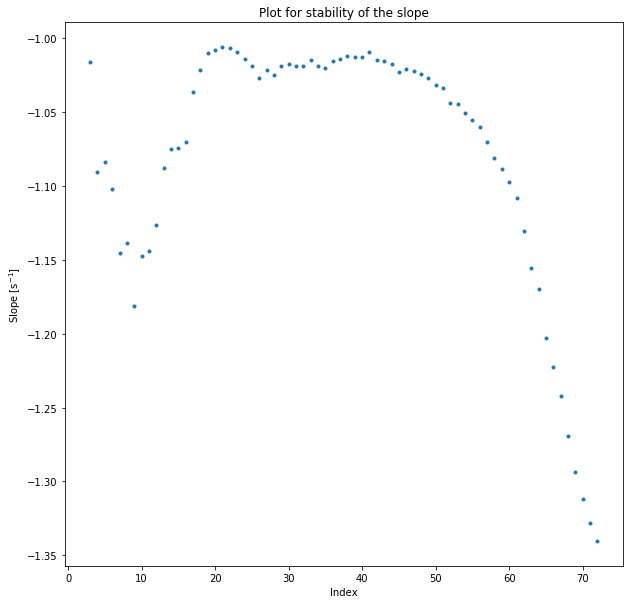

In [32]:
# Compute vectors with logarithm of frequences and centers of edges in order to perform linear regression
xy = pd.DataFrame({'x':x, 'y':y})
xy = xy[ xy.y != 0 ] # Drop bin with zero frequency in order to compute the logarithm
x_reg = np.log10(np.array(xy.x))
y_reg = np.log10(np.array(xy.y))

# Perfom linear regression after removing elements from x_m to the end of the vector
alpha = []
x_part = []

for i in range(3,len(x_reg)):
    x_prov = x_reg[:i]
    y_prov = y_reg[:i]
    model = LinearRegression().fit(x_prov.reshape(-1,1), y_prov.reshape(-1,1))
    alpha.append(model.coef_[0][0])
    x_part.append(i)

fig = plt.subplots(figsize=(10,10))
plt.plot(x_part,alpha,'.')
plt.title('Plot for stability of the slope')
plt.xlabel('Index')
plt.ylabel('Slope [s$^{-1}$]')
plt.show()

Intercept: [-0.81538334]
Slope: [[-1.00920352]]


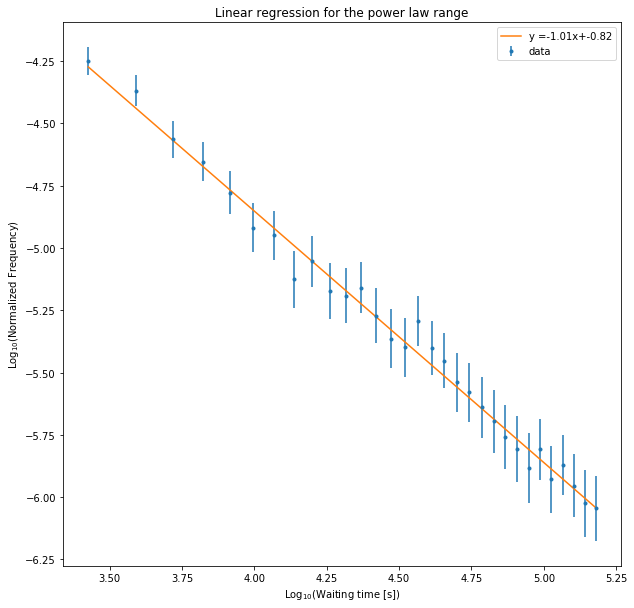

In [33]:
# Choose best lower bound
slope = []
chosen_index = []

for i in range(len(x_part)-5): # Compute the slope for al consecutive set of five points
    x_set = np.array(x_part[i:i+5])
    y_set = np.array(alpha[i:i+5])
    model = LinearRegression().fit(x_set.reshape(-1,1), y_set.reshape(-1,1))
    chosen_index.append(i+5)
    slope.append(model.coef_[0][0])

data_tuples = list(zip(chosen_index,slope))
g = pd.DataFrame(data_tuples,columns=['x_min_index','slope'])
g['slope'] = np.abs(g['slope'])
x_min_index =  np.array(g.loc[g['slope'] == g['slope'].min()]) # Choose the last point of the set with lower bound

# Perform linear regression with the best value x_min
x_corr = np.array(x_reg[1:int(x_min_index[0][0])])
y_corr = np.array(y_reg[1:int(x_min_index[0][0])])

model = LinearRegression().fit(x_corr.reshape(-1,1), y_corr.reshape(-1,1))

print('Intercept:', model.intercept_)
print('Slope:', model.coef_)

y_error_corr = np.divide(y_error[1:int(x_min_index[0][0])],y[1:int(x_min_index[0][0])]) # Compute errors

# Plot fit
l = np.linspace(x_corr.min(), x_corr.max(),len(x_corr))

fig = plt.subplots(figsize=(10,10))
plt.errorbar(x_corr, y_corr,yerr=y_error_corr,fmt='.')
plt.plot(l, model.intercept_[0] + model.coef_[0][0]*l)
plt.title('Linear regression for the power law range')
plt.xlabel('Log$_{10}$(Waiting time [s])')
plt.ylabel('Log$_{10}$(Normalized Frequency)')
plt.legend(('y ={0:01.2f}x{1:01.2f}'.format(model.coef_[0][0],model.intercept_[0]),'data'))
plt.show()

### 5.4 - Analysis for different values of $m$ and $R$ <a class="anchor" id="5.4"></a>
* [Index](#0)

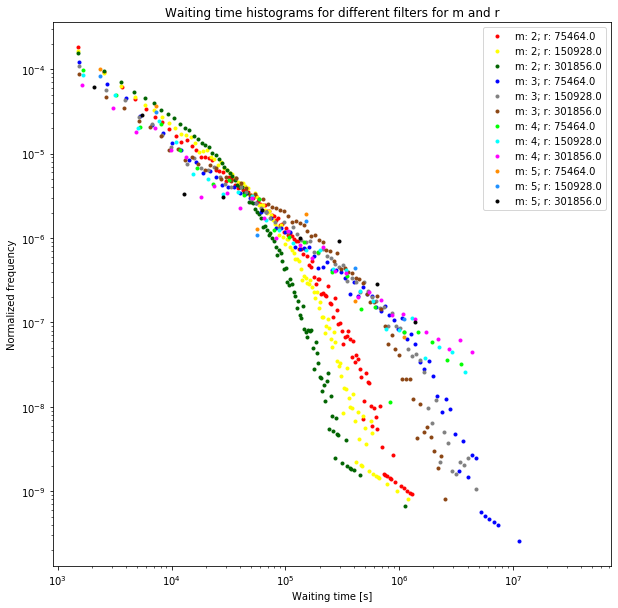

In [34]:
# Set the values of m
mag = [2,3,4,5]

# Initialize r
r = [0,0,0]

# Inizialize vectors
xx = np.empty((len(mag),len(r)), object)
yy = np.empty((len(mag),len(r)), object)
mean = np.empty((len(mag),len(r)))
length = np.empty((len(mag),len(r)))

# Create figure 
fig, axes = plt.subplots(nrows=len(mag), ncols=len(r), figsize=(20,20))
fig1, axes1 = plt.subplots(nrows=len(mag), ncols=len(r), figsize=(20,20))


for i in range(len(mag)):    
    df_red = copy.deepcopy(df[df['magnitude'] >= mag[i]])
    df_red['distance'] = np.sqrt((df_red['X'].diff(periods=-1))**2 + (df_red['Y'].diff(periods=-1))**2 + 
                                 (df_red['Z'].diff(periods=-1))**2)     
    df_red = df_red.dropna()  
    r = df_red['distance'].mean()
    r = [r/2,r,2*r]
    
    for j in range(len(r)):        
        df_r = copy.deepcopy(df_red[df_red['distance']<r[j]])
        df_r['waiting'] = np.abs(df_r['time'].diff(periods=-1)) # Compute the waiting time 
        df_r = df_r.dropna()
        width = 1000*np.logspace(0, 3, int(np.sqrt(df_r.shape[0]))+1)
        edge = np.cumsum(width)
        title = "m: {}; r:{}".format(round(mag[i],2),round(r[j],2))
        axes[i,j].set_title(title)    
        axes[i,j].set_xlim(0,200000)
        axes[i,j].set_xlabel('waiting')
        axes[i,j].set_ylabel('frequency')
        ax = sns.distplot(df_r['waiting'], bins = edge, kde=False, norm_hist=True, ax=axes[i,j])
        edge = np.array([h.get_xy()[0] for h in ax.patches]) # Left edges
        width = np.array([h.get_width() for h in ax.patches]) 
        xx[i,j] =  np.array(np.add(edge, width/2.)) # Center of bins 
        yy[i,j] =  np.array([h.get_height() for h in ax.patches]) # Frequency of data 
        mean[i,j] = df_r['waiting'].mean()
        length[i,j] = df_r['distance'].max() 
        plt.close()

color = ['red','yellow','darkgreen','blue','grey','saddlebrown','lime','aqua','magenta','darkorange',
         'dodgerblue','black']

fig, ax = plt.subplots(figsize=(10,10))

ax.set_xscale('log')
ax.set_yscale('log')

for i in range(len(mag)):
    for j in range(len(r)):
        xx[i,j] = xx[i,j]
        yy[i,j] = yy[i,j]
        
        ax.plot(xx[i,j],yy[i,j],'.',label="m: {}; r: {}".format(round(mag[i],2),round(r[j],0)),
                c=color[3*i+j]) 

ax.legend()
ax.set_title('Waiting time histograms for different filters for m and r')
ax.set_xlabel('Waiting time [s]')
ax.set_ylabel('Normalized frequency')
plt.show()

## 6 - Rescaling <a class="anchor" id="6"></a>
* [Index](#0)

Suppose we have some probability distribution $p(x)$ for a quantity $x$, and satisfies the property that, for any $b$: $$ p(bx) = g(b)p(x) $$
If we increase the scale or units by which we measure $x$ by a factor of $b$, the shape of the distribution $p(x)$ is unchanged, except for an overall multiplicative constant. A power law distribution behaves as a scale-free distribution. 

Rescaling the data by a charateristic size they collapse into the same curve.

In particular, rescaling is achieved by: 
$$ x = \frac{\Delta d}{L}, \quad  y = \Delta d \times L$$ 
where $\Delta d$ is the center of bins over which the probability is calculated.

### 6.1 - Rescaling $P_m(t)$ <a class="anchor" id="6.1"></a>
* [Index](#0)

We rescale waiting time distribution for different values of $m$ using as characteristic length the average waiting time.

Indeed, we observe that, by plotting average waiting time vs $m$, it turns out they are proportional as expected. Intuitively, the slope of the line they build up is related to the coefficient of proportionality.

Text(0, 0.5, 'Average waiting time [s]')

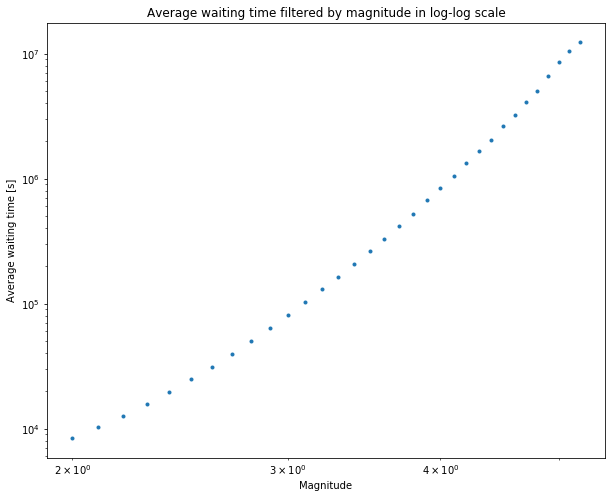

In [35]:
# Read data from file and make sure earthquakes are ordered by time
cols = ['index', 'trigger', 'time', 'magnitude', 'X', 'Y', 'Z']
df = pd.read_table("SouthCalifornia-1982-2011_Physics-of-Data.dat",sep=" ",header=None)
df.columns = cols
df = df.sort_values(by = ['time'])

mag_interval = list(np.arange(df['magnitude'].min(),df['magnitude'].max()-2,0.1)) # Set the values of m
waiting_mean = []

for i in range(len(mag_interval)): # Compute the average waiting time after filtering for given m
    df_red = copy.deepcopy(df[df['magnitude'] >= mag_interval[i]])
    df_red['waiting'] = np.abs(df_red['time'].diff(periods=-1)) # Compute the waiting time 
    df_red = df_red.dropna()
    waiting_mean.append(df_red['waiting'].mean())
    
fig = plt.subplots(figsize=(10,8))
plt.plot(mag_interval,waiting_mean,'.')
plt.xscale('log')
plt.yscale('log')
plt.title('Average waiting time filtered by magnitude in log-log scale')
plt.xlabel('Magnitude')
plt.ylabel('Average waiting time [s]')

Moreover, we plot the dotted histogram with logarithminc binning for varius values of $m$ after rescaling and we observe that data collapses on the same curve as expected.

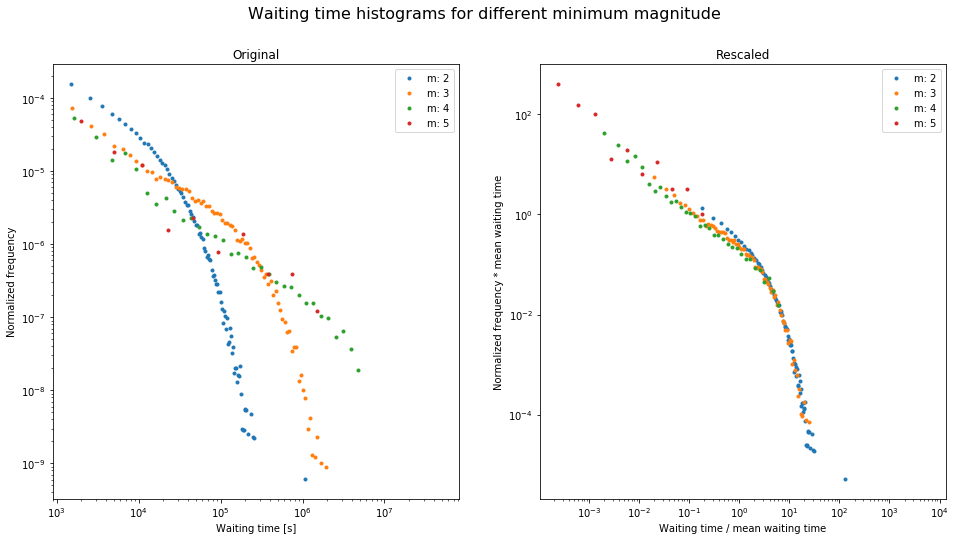

In [36]:
# Rescale waiting time multiplying frequency for average waiting time and dividing waiting time for average waiting time
xx_waiting_res = [0,0,0,0]
yy_waiting_res = [0,0,0,0]

for i in range(len(mag)):
    xx_waiting_res[i] = xx_waiting[i]/w_mean[i]
    yy_waiting_res[i] = yy_waiting[i]*w_mean[i]

fig, ax = plt.subplots(1,2,figsize=(16,8))

fig.suptitle('Waiting time histograms for different minimum magnitude', fontsize=16)
for i in range(len(mag)):
    ax[0].plot(xx_waiting[i],yy_waiting[i],'.',label="m: {}".format(i+2))
    ax[0].set_xscale('log')
    ax[0].set_yscale('log')
    ax[0].set_title('Original')
    ax[0].set_xlabel('Waiting time [s]')
    ax[0].set_ylabel('Normalized frequency')
    ax[0].legend()
    
for i in range(len(mag)):
    ax[1].plot(xx_waiting_res[i],yy_waiting_res[i],'.',label="m: {}".format(i+2))
    ax[1].set_xscale('log')
    ax[1].set_yscale('log')
    ax[1].set_title('Rescaled')
    ax[1].set_xlabel('Waiting time / mean waiting time')
    ax[1].set_ylabel('Normalized frequency * mean waiting time')
    ax[1].legend()

plt.show()

### 6.2 - Rescaling  $P_m(r)$ <a class="anchor" id="6.2"></a>
* [Index](#0)

We perform a similar procedure for distances using as characteristic length the maximum distance for each $m$. In this case we observe no significative rescaling. In fact observing the plot of maximum distances vs magnitude we notice that the coefficient of proportionality seems to be close to one. 

Text(0, 0.5, 'Maximum distance [m]')

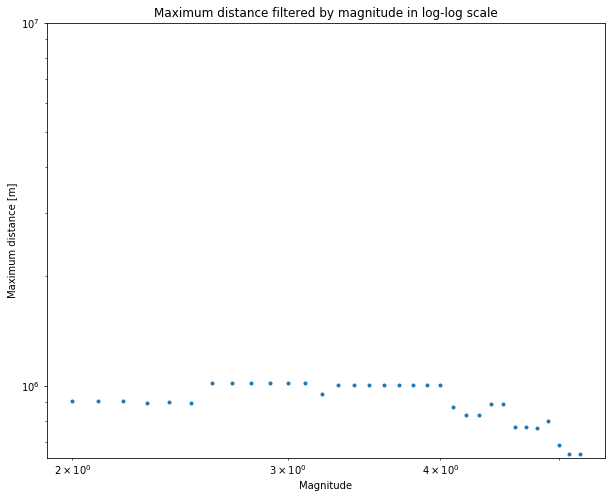

In [37]:
# Read data from file and make sure earthquakes are ordered by time
cols = ['index', 'trigger', 'time', 'magnitude', 'X', 'Y', 'Z']
df = pd.read_table("SouthCalifornia-1982-2011_Physics-of-Data.dat",sep=" ",header=None)
df.columns = cols
df = df.sort_values(by = ['time'])

mag_interval = list(np.arange(df['magnitude'].min(),df['magnitude'].max()-2,0.1)) # Set the values of m
distance_max = []

for i in range(len(mag_interval)): # Compute the maximum distance after filtering for given m
    df_red = copy.deepcopy(df[df['magnitude'] >= mag_interval[i]])
    df_red['distance'] = np.sqrt((df_red['X'].diff(periods=-1))**2 + (df_red['Y'].diff(periods=-1))**2 + 
                                 (df_red['Z'].diff(periods=-1))**2)
    df_red = df_red.dropna()
    distance_max.append(df_red['distance'].max())
    
fig = plt.subplots(figsize=(10,8))
plt.plot(mag_interval,distance_max,'.')
plt.xscale('log')
plt.yscale('log')
plt.ylim(0,10000000)
plt.title('Maximum distance filtered by magnitude in log-log scale')
plt.xlabel('Magnitude')
plt.ylabel('Maximum distance [m]')

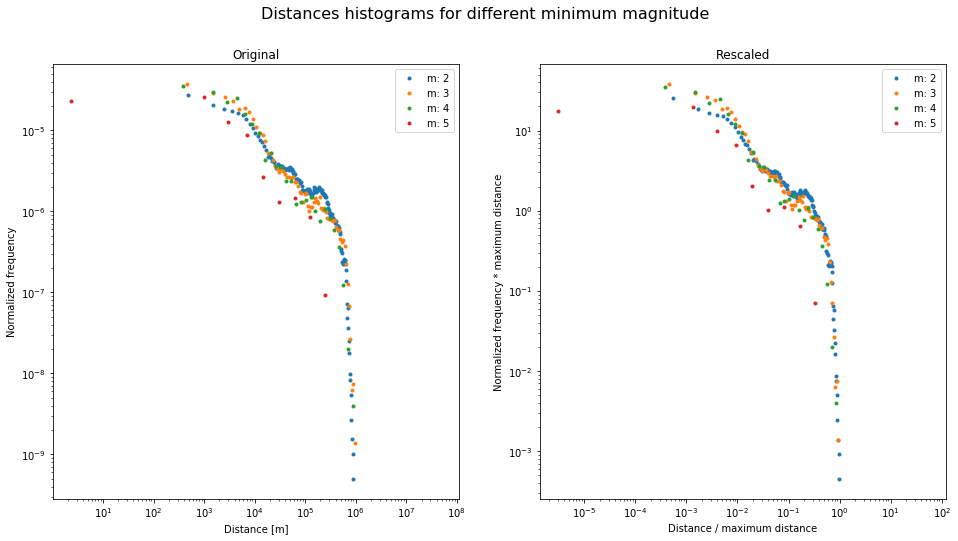

In [38]:
# Rescale distance multiplying frequency for maximum distance and dividing distance for maximum distance
xx_dist_res = [0,0,0,0]
yy_dist_res = [0,0,0,0]

for i in range(len(mag)):
    xx_dist_res[i] = xx_dist[i]/max_dist[i]
    yy_dist_res[i] = yy_dist[i]*max_dist[i]

fig, ax = plt.subplots(1,2,figsize=(16,8))

fig.suptitle('Distances histograms for different minimum magnitude', fontsize=16)
for i in range(len(mag)):
    ax[0].plot(xx_dist[i],yy_dist[i],'.',label="m: {}".format(i+2))
    ax[0].set_xscale('log')
    ax[0].set_yscale('log')
    ax[0].set_title('Original')
    ax[0].set_xlabel('Distance [m]')
    ax[0].set_ylabel('Normalized frequency')
    ax[0].legend()
    
for i in range(len(mag)):
    ax[1].plot(xx_dist_res[i],yy_dist_res[i],'.',label="m: {}".format(i+2))
    ax[1].set_xscale('log')
    ax[1].set_yscale('log')
    ax[1].set_title('Rescaled')
    ax[1].set_xlabel('Distance / maximum distance')
    ax[1].set_ylabel('Normalized frequency * maximum distance')
    ax[1].legend()

plt.show()

### 6.3 - Reascaling $P_{m,R}(t)$  <a class="anchor" id="6.3"></a>
* [Index](#0)

Eventually, we rescale the distribution of waiting time between events with magnitude above $m$ and closer than $R$; we use as characteristic length the product between avearage waiting time and maximum distance for a fixed $m$. In this case, we observe the collapse of data on the same curve. 

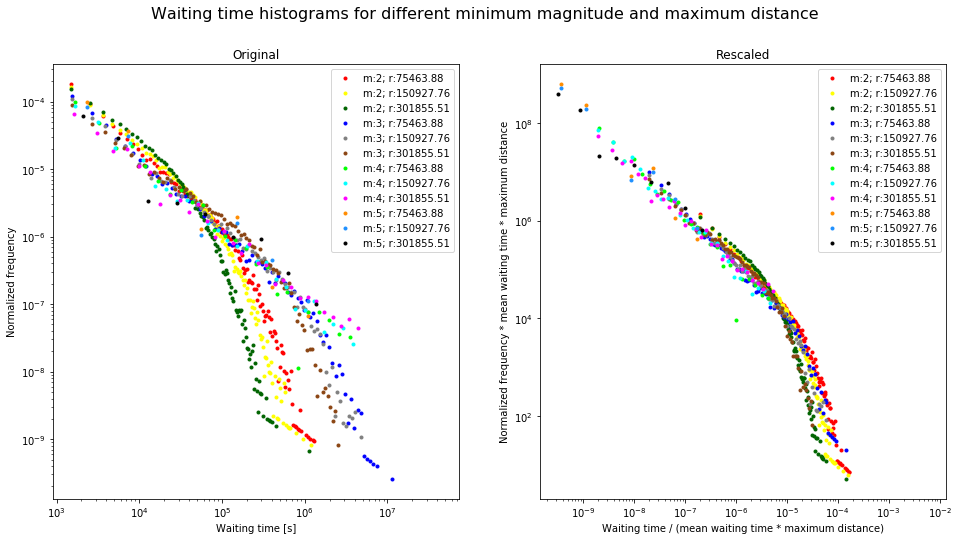

In [39]:
# Rescale distance and waiting time
xx_res = np.empty((len(mag),len(r)), object)
yy_res = np.empty((len(mag),len(r)), object)

color = ['red','yellow','darkgreen','blue','grey','saddlebrown','lime','aqua','magenta','darkorange',
         'dodgerblue','black']

for i in range(len(mag)):
    for j in range(len(r)):  
        xx_res[i,j] = xx[i,j]/(w_mean[i]*max_dist[i])
        yy_res[i,j] = yy[i,j]*w_mean[i]*max_dist[i]
        
fig, ax = plt.subplots(1,2,figsize=(16,8))

fig.suptitle('Waiting time histograms for different minimum magnitude and maximum distance', fontsize=16)
for i in range(len(mag)):
    for j in range(len(r)):
        ax[0].plot(xx[i,j],yy[i,j],'.',label="m:{}; r:{}".format(round(mag[i],2),round(r[j],2)),
                   c=color[3*i+j] )
        ax[0].set_xscale('log')
        ax[0].set_yscale('log')
        ax[0].set_title('Original')
        ax[0].set_xlabel('Waiting time [s]')
        ax[0].set_ylabel('Normalized frequency')
        ax[0].legend()
    
for i in range(len(mag)):
    for j in range(len(r)):
        ax[1].plot(xx_res[i,j],yy_res[i,j],'.',label="m:{}; r:{}".format(round(mag[i],2),round(r[j],2)),
                   c=color[3*i+j] )
        ax[1].set_xscale('log')
        ax[1].set_yscale('log')
        ax[1].set_title('Rescaled')
        ax[1].set_xlabel('Waiting time / (mean waiting time * maximum distance)')
        ax[1].set_ylabel('Normalized frequency * mean waiting time * maximum distance')
        ax[1].legend()
        
plt.show()

More specifically, the collapse of the data for waiting time and distances as a result of rescaling of the respective values, is an indication of a critical phenomenon. This scale-free behaviour suggests that the earthquakes could belong to the class of the self-organized criticality (SOC), however, that the simplest SOC models cannot reproduce all the important features of critical phenomena.

In physics, self-organized criticality (SOC) is a property of dynamical systems that have a critical point as an attractor. It obeys the following characteristics:
* Individual events are statistically independent, spatially and temporally.
* The size or occurrence frequency distribution is scale-free, characterized by a power law distribution.
* Spatial and temporal evolution is complex. 

Their macroscopic behavior thus displays the spatial or temporal scale-invariance characteristic of the critical point of a phase transition, but without the need to tune control parameters to a precise value, because the system, effectively, tunes itself as it evolves towards criticality.

## 7 - Conclusion <a class="anchor" id="7"></a>
* [Index](#0)

In conclusion, seismicity is a complex spatiotemporal phenomenon which obeys certain general laws.
In this project, we have analyzed data of earthquakes in South California in a thirty year time span and we have observed a power law dacay for both waiting times and distances distributions for events closer in time and space than a threshold, which corresponds to the lower bound we have fixed in each case. 

We have also observed a rescaling behaviour as far as waiting time distribution is concerned, while in the case of distances the reascaling behaviour is not appreciable. However, we can say that waiting times and distance of subsequent earthquakes are part of a single scaling picture and that some property of earthquakes can be described in a SOC model.

## References

[1] - Elisaveta Marekova, Plovdiv University “Paisiy Hilendarski", "Analysis of the Spatial Distribution between Successive Earthquakes Occurred in Various Regions in the World", (2014)

[2] - Marco Baiesi, Instituut voor Theoretische Fysica, K.U.Leuven, B-3001, Belgium, "Correlated earthquakes in a self-organized model", (2009)

[3] - Antoni M. Correig, Universitat de Barcelona Spain, "On the Power Law Statistical Distribution of Observations", (2009)